In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        folds=10,
                        random_state=42
                       )

In [6]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
count,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,...,3.094700e+04,3.094700e+04,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000
mean,73.719667,46.264479,38.909376,33.446607,30.420424,30.067026,29.524960,29.485805,29.035557,28.434550,...,-1.984839e-02,-1.938723e-02,14.260070,25.679845,5.237762,22.727680,4.911355,0.676673,24.927586,5.471936
std,30.473942,18.374510,17.074185,14.922491,14.885459,15.237449,15.111426,15.600575,15.600374,15.252728,...,2.085811e-01,2.070859e-01,22.763022,35.058448,15.400834,17.316189,3.410737,0.467754,14.392002,2.889230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-7.458212e-01,-7.421038e-01,3.736712,6.454405,1.436722,0.000000,0.510542,0.000000,0.000000,1.000000
25%,54.270596,34.628251,27.134954,22.152604,17.779317,16.509955,16.142753,15.170072,14.981445,14.189170,...,-1.659554e-01,-1.654091e-01,9.477854,17.833900,3.478282,14.893102,2.640077,0.000000,12.000000,3.000000
50%,74.850493,46.716638,38.133677,33.581847,30.752174,30.586093,30.338455,30.395567,30.146264,29.760050,...,-5.277997e-09,-8.137921e-09,11.984384,21.852503,4.507795,18.785621,4.292363,1.000000,25.000000,5.000000
75%,93.894152,58.166543,50.129512,44.366403,41.731754,42.094875,41.359002,41.674235,40.984961,40.346104,...,1.163689e-01,1.146088e-01,15.742905,27.626522,5.601991,25.275695,6.459832,1.000000,38.000000,8.000000
max,208.957500,123.849951,118.728586,92.085252,89.965195,89.935857,113.100970,118.224343,120.085079,113.077150,...,8.572066e-01,7.961318e-01,2206.362673,5031.091987,2444.047253,620.895529,156.366775,1.000000,49.000000,10.000000


In [7]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [8]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['target']

In [9]:
from data_utils import balanced_supersample, balanced_subsample
# train_X, train_y = balanced_subsample(train_X, train_y)

In [10]:
train_y=train_y.squeeze()
print(train_X.shape)
print(train_y.shape)

(22143, 129)
(22143,)


# Deep Net
Separate into classes

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

In [12]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(129,)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [18]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)

clf = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=50, 
                       batch_size=35, 
                       validation_split=0.15)

history = clf.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
__________

18821/18821 [==============================] - 1s 73us/step - loss: 3.0273 - acc: 0.1629 - val_loss: 2.9138 - val_acc: 0.2002
Epoch 49/50
18821/18821 [==============================] - 1s 66us/step - loss: 3.0156 - acc: 0.1605 - val_loss: 2.9021 - val_acc: 0.2011
Epoch 50/50
18821/18821 [==============================] - 1s 63us/step - loss: 3.0174 - acc: 0.1619 - val_loss: 2.9888 - val_acc: 0.1728


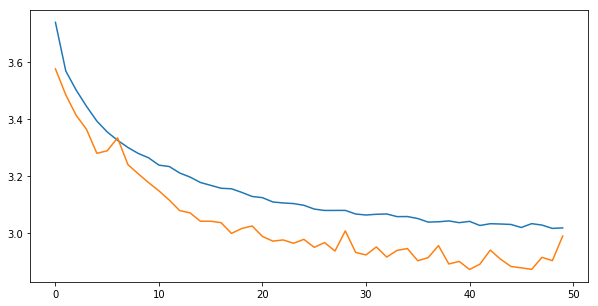

In [19]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

0.02601156069364162
Confusion matrix, without normalization
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


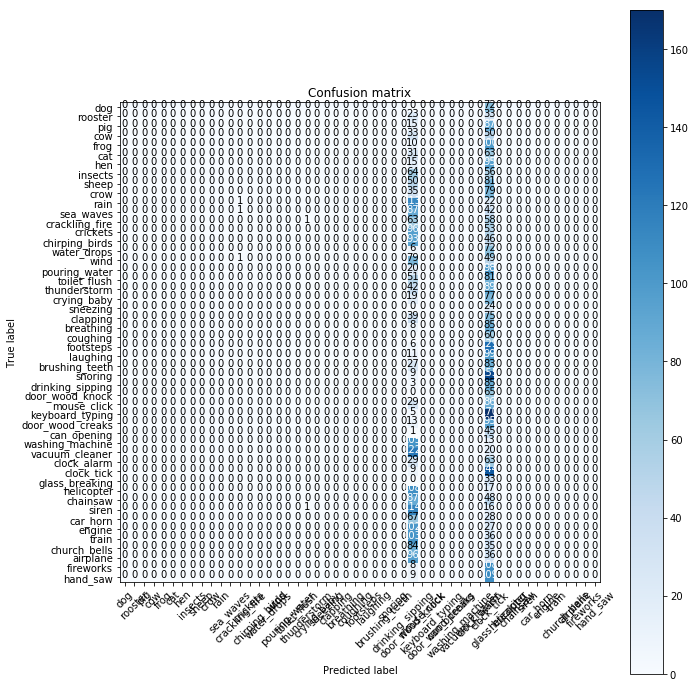

In [20]:
test_X = scaler.transform(test_X)

pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()

# All Data

In [21]:
all_df = df[df.fold == 1]

In [22]:
X = all_df.drop(['target', 'h_target', 'fold'], axis=1)
y = all_df['target']
X = scaler.fit_transform(X)

0.08629130966952264
Confusion matrix, without normalization
[[ 0  0  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 [ 0  9  0 ...  1  0  6]
 ...
 [ 0 10  0 ...  0  0  1]
 [ 0  7  0 ...  1  0  0]
 [ 0 14  0 ...  0  0 29]]


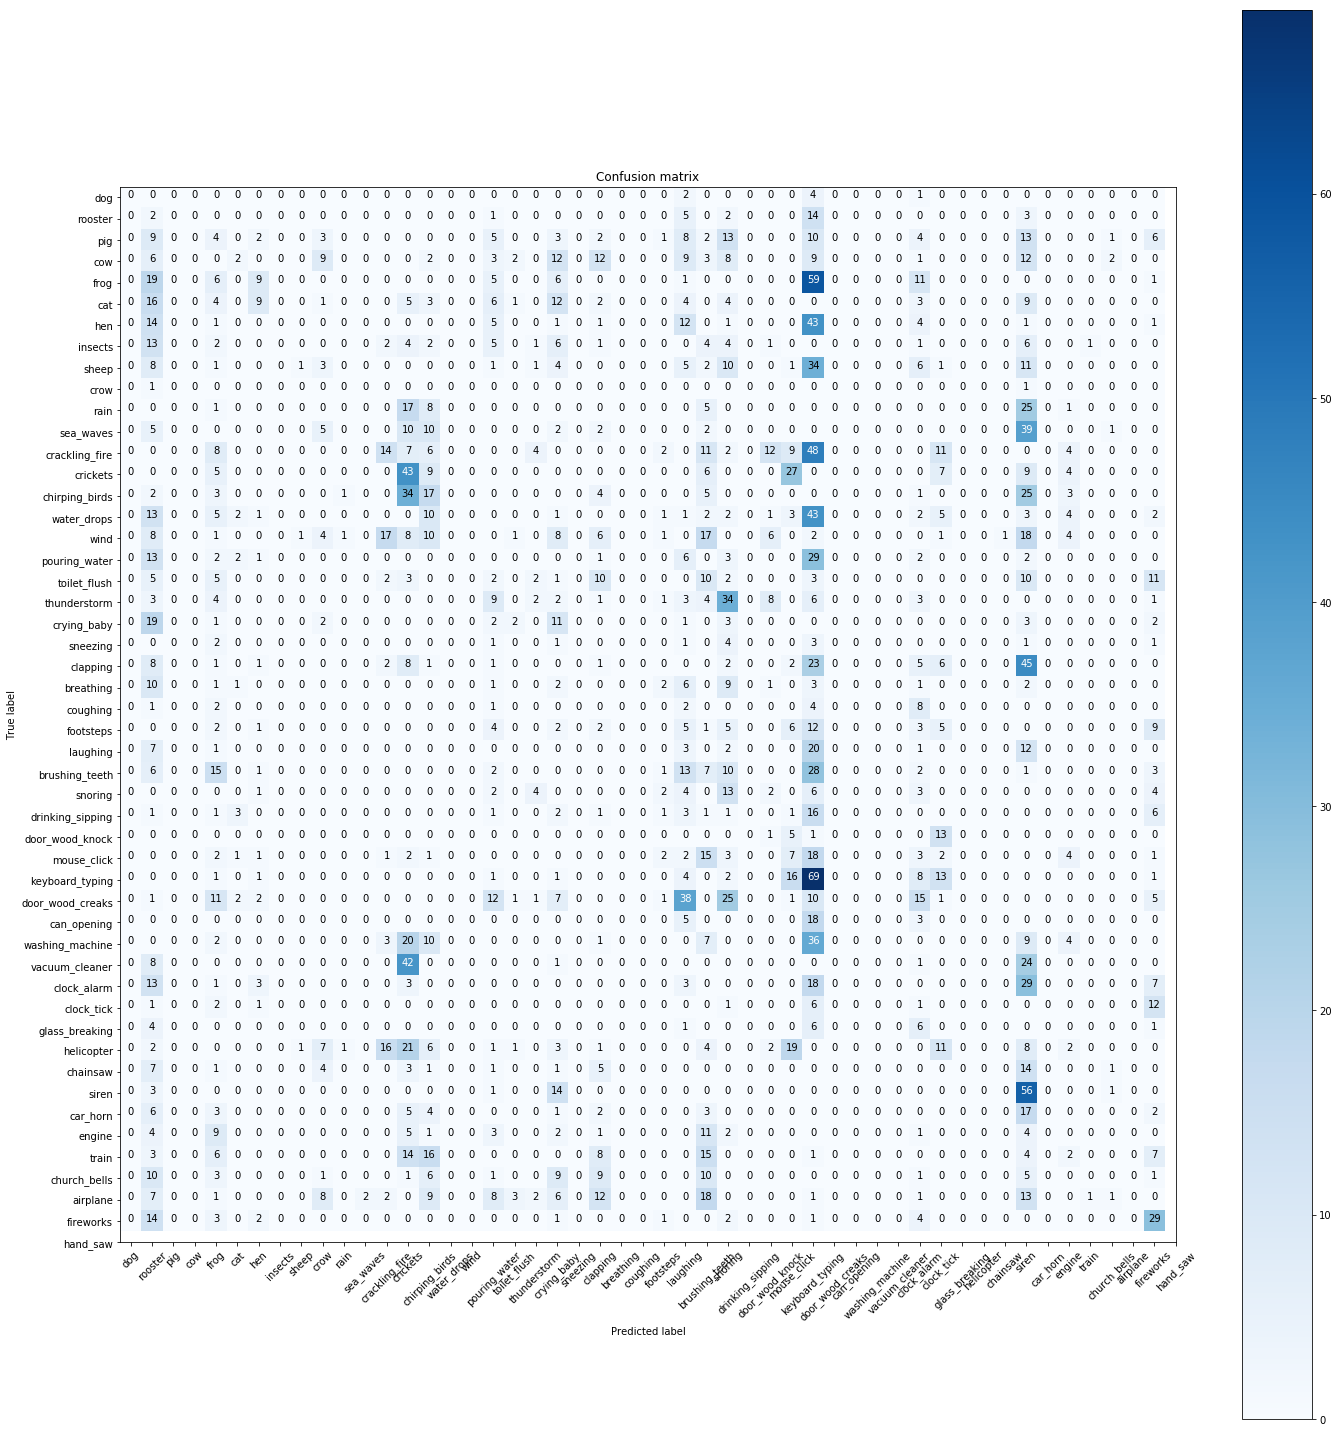

In [23]:
pred = clf.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()